## Energy Consumption Prediction

### The dataset is obtained from Kaggle Dataset, and the original data is obtained from PJM Interconnection LLC.

### PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

### The hourly power consumption data comes from PJM's website and are in megawatts (MW).

### There are more than one power company's data in the original dataset. We will only explore the AEP (American Electrical Power) dataset in this project.

## Models

### 1. Moving Average (MA)
### 2. Seasonal Autoregressive Integrated Moving Average (SARIMA)
### 3. Holt Winter Exponential Smoothing (HWES)
### 4. Facbook - Prophet
### 5. Recurrent Neural Network - Long Short Term Memory (LSTM)
### 6. Supervised Learning - XGBoost

## Evaluation Metric
### Mean Absolute Percentage Error (MAPE)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.tsa.arima_model import ARMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from pandas import concat

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller

Using TensorFlow backend.


In [2]:
from fbprophet import Prophet

import timeit

## Data Exploration

In [3]:
df=pd.read_csv('AEP_hourly.csv')

In [4]:
df.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [5]:
df.columns=['Time','MW']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
Time    121273 non-null object
MW      121273 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [7]:
ts=pd.DataFrame(df['MW'])

## Indexing with Time Series Data

In [8]:
ts=ts.set_index(pd.to_datetime(df['Time']))
ts.head()

,MW
Time,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


## Visualizing Energy Consumption Time Series Data

<Figure size 1080x720 with 0 Axes>

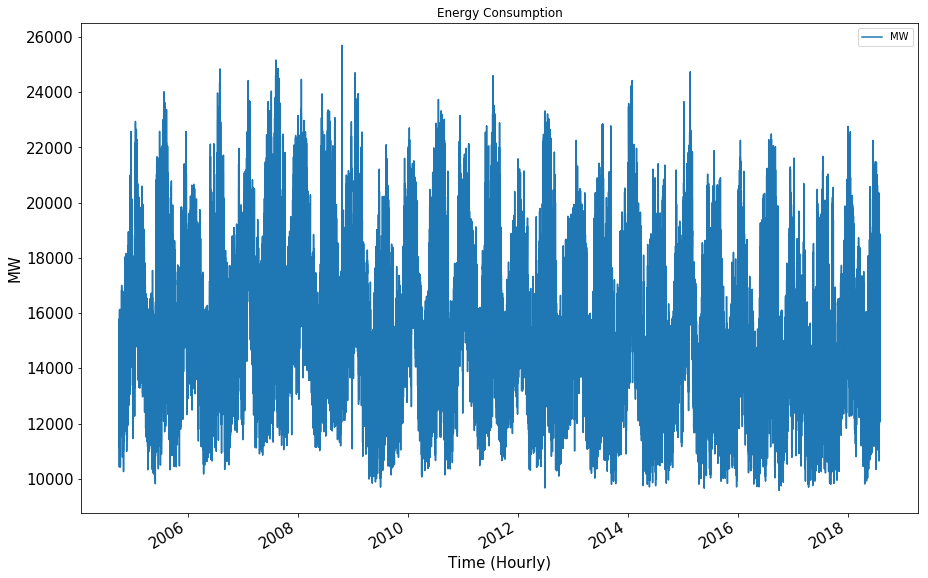

In [9]:
rcParams['figure.figsize'] = 15, 10
fig = plt.figure()
#plt.plot(ts)
ts.plot(fontsize=15)
plt.title('Energy Consumption')
plt.xlabel('Time (Hourly)', fontsize=15)
plt.ylabel('MW', fontsize=15)
plt.show()

### It is hard to tell what is going on with the original hourly energy consumption date. We can convert the original hourly data to monthly one and visualize the monthly energy consumption data instead.

In [10]:
y = ts['MW'].resample('MS').mean()

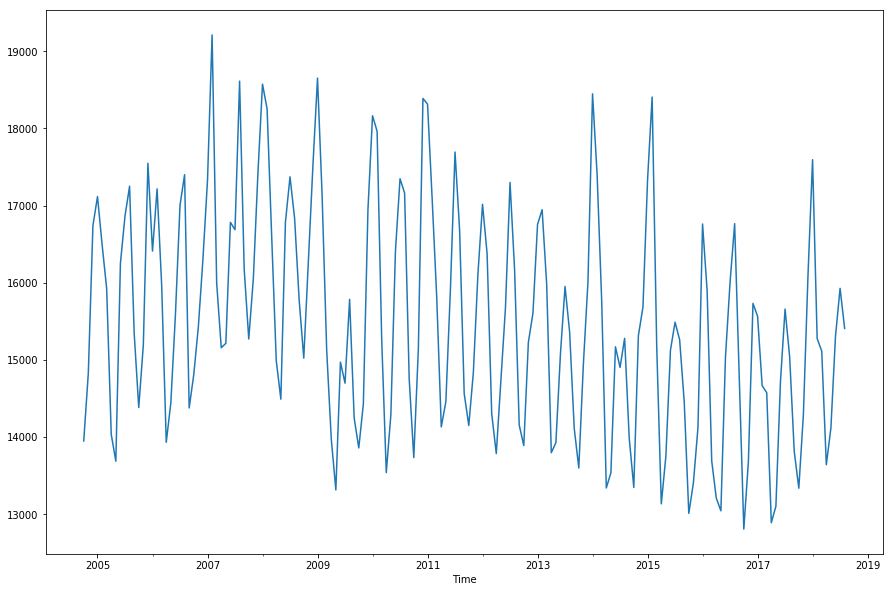

In [11]:
y.plot()
plt.show()

### Some distinguishable patterns appear when we plot the data. The time series has an obvious seasonality pattern, as well as an increasing, decreasing, and increasing trend.

## Stationarity Checking

## 1. Augmented Dickey-Fuller Test
### Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
### Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
### p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
### p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

In [12]:
result_test = adfuller(y)
print('ADF Statistic: %f' % result_test[0])
print('p-value: %f' % result_test[1])
print('Critical Values:')
for key, value in result_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.696009
p-value: 0.433170
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


## 2. Decomposition
### We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

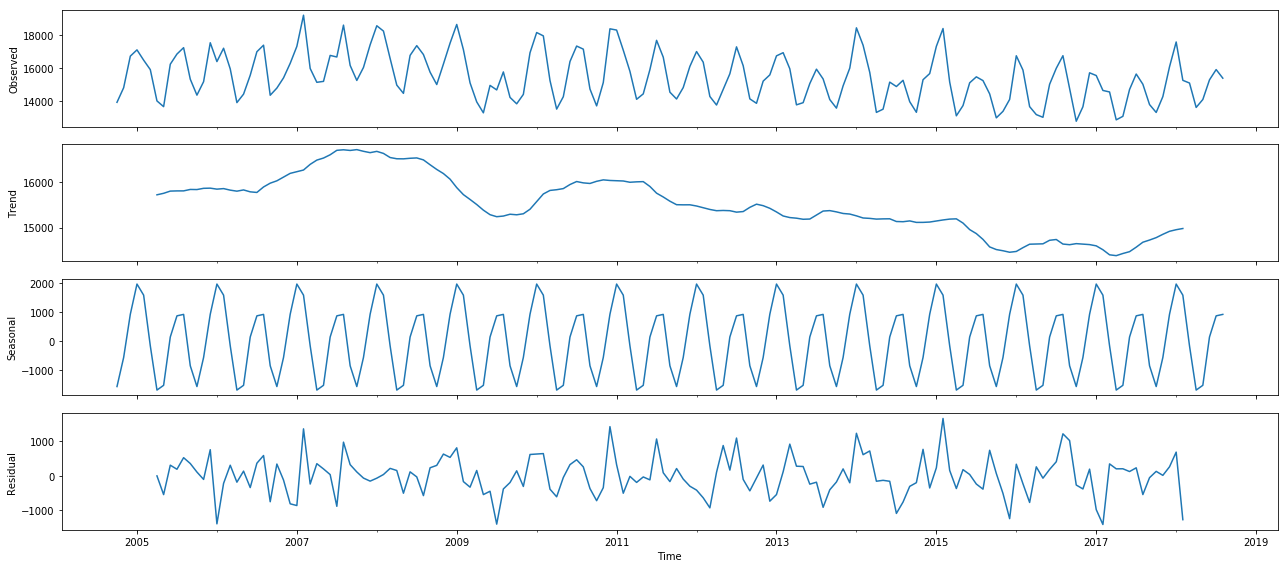

In [13]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### The plot above clearly shows that the energy consumption is unstable, along with its obvious seasonality.

## Train/Test Split¶
### Cut off the data after 2017-01-01 to use as our validation set.

In [14]:
split_date = '2017-01-01'
y_train = y.loc[y.index < split_date].copy()
y_test = y.loc[y.index >= split_date].copy()

## Define Evaluation Metrics

In [15]:
def MAPE(forecast,truth,model,df):
    diff=forecast-truth
    MAPE=str(round(abs(diff/truth).mean()*100,2))+'%'
    df['MAPE'][model]=MAPE
    print('The Mean Absolute Percentage Error (MAPE) of our forecasts is {}'.format(MAPE))

## Define a result table

In [16]:
result_df_index=['MA',
                 'SARIMA',
                 'HWES',
                 'Prophet',
                 'LSTM',
                 'XGBoost']
result_df_col=['Time','MAPE']

result_df=pd.DataFrame(index=result_df_index, columns=result_df_col)
result_df

,Time,MAPE
MA,NaN,NaN
SARIMA,NaN,NaN
HWES,NaN,NaN
Prophet,NaN,NaN
LSTM,NaN,NaN
XGBoost,NaN,NaN


## 1. Moving Average Model

In [17]:
start=timeit.default_timer()
model_MA = ARMA(y_train,order=(0,1))
model_MA_fit = model_MA.fit()
stop=timeit.default_timer()
result_df['Time']['MA']=round(stop-start,2)
print('Lag: %s' % model_MA_fit.k_ar)
print('Coefficients: %s' % model_MA_fit.params)

Lag: 0
Coefficients: const       15595.810563
ma.L1.MW        0.636996
dtype: float64


In [18]:
pred_MA = model_MA_fit.predict(start=pd.to_datetime(split_date),
                              end=y.index.max(),
                              dynamic=False)

In [19]:
MAPE(pred_MA,y_test,'MA',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 7.74%


## 2. Holt Winter’s Exponential Smoothing (HWES)

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing

In [21]:
model_HW = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add')

In [22]:
start=timeit.default_timer()
model_HW_fit=model_HW.fit()
stop=timeit.default_timer()
result_df['Time']['HWES']=round(stop-start,2)

In [23]:
pred_HW = model_HW_fit.predict(start=pd.to_datetime(split_date),
                              end=y.index.max())

2017-01-01    16756.511794
2017-02-01    16466.390074
2017-03-01    14580.546139
2017-04-01    13074.462031
2017-05-01    13209.917793
2017-06-01    14882.024663
2017-07-01    15567.300082
2017-08-01    15697.735813
2017-09-01    13853.703193
2017-10-01    13129.089022
2017-11-01    14148.039967
2017-12-01    15758.274598
2018-01-01    16756.524249
2018-02-01    16466.402529
2018-03-01    14580.558594
2018-04-01    13074.474486
2018-05-01    13209.930248
2018-06-01    14882.037118
2018-07-01    15567.312537
2018-08-01    15697.748268
Freq: MS, dtype: float64

In [24]:
MAPE(pred_HW,y_test,'HWES',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 3.34%


# 3. SARIMA

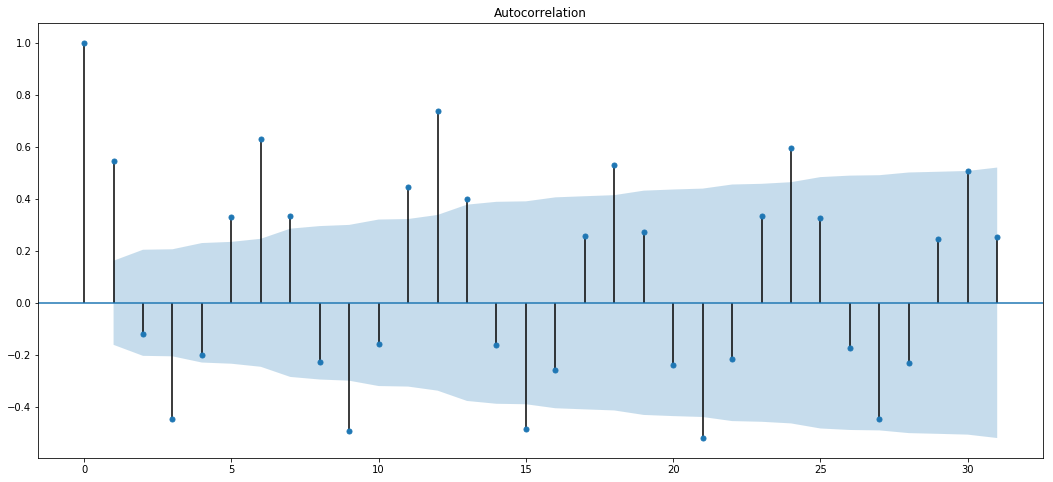

In [25]:
plot_acf(y_train, lags=31, alpha=0.05)
plt.show()

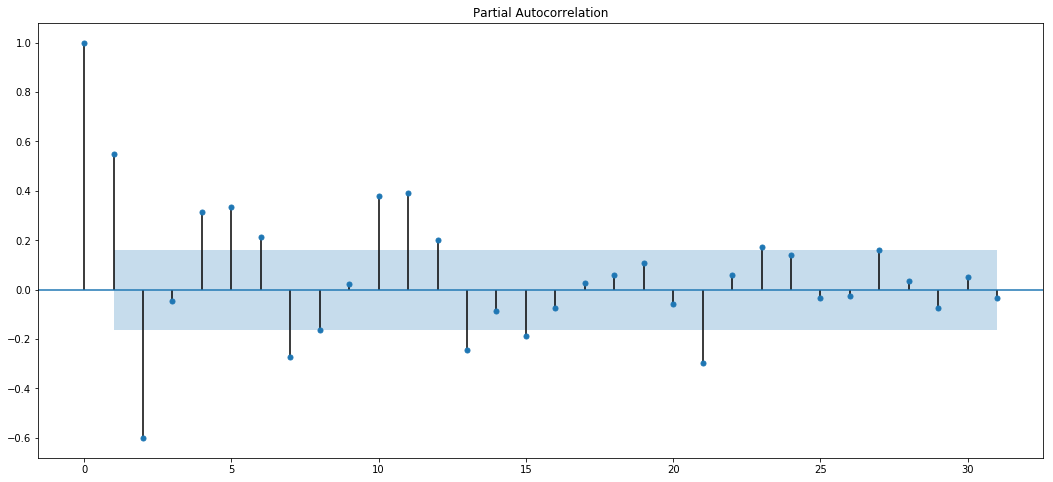

In [26]:
plot_pacf(y_train, lags=31, alpha=0.05)
plt.show()

## Parameter Selection for the ARIMA Time Series Model
### We will select the optimum ARIMA model with the lowest AIC (Akaike Information Criterion) value. A grid search technique will be used to find the optimal parameters in (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters, and in (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [28]:
opt_pdq=(0,0,0)
opt_PDQ=(0,0,0,0)
opt_AIC=10000

In [29]:

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic<opt_AIC:
                opt_pdq=param
                opt_PDQ=param_seasonal
                opt_AIC=results.aic
        except:
            continue

print('Optimal SARIMA Model {}x{} - AIC:{}'.format(opt_pdq, opt_PDQ, opt_AIC))

C:\Users\SH\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1052: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:
C:\Users\SH\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


Optimal SARIMA Model (0, 1, 1)x(1, 1, 1, 12) - AIC:2171.5677355806674


## Fitting an ARIMA Time Series Model
### Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

### We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [30]:
start=timeit.default_timer()
model_SARIMA = sm.tsa.statespace.SARIMAX(y_train,
                                order=opt_pdq,
                                seasonal_order=opt_PDQ,
                                enforce_stationarity=True,
                                enforce_invertibility=False)
model_SARIMA_fit = model_SARIMA.fit()
stop=timeit.default_timer()
result_df['Time']['SARIMA']=round(stop-start,2)
print(model_SARIMA_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4688      0.051     -9.180      0.000      -0.569      -0.369
ar.S.L12       0.2514      0.128      1.970      0.049       0.001       0.502
ma.S.L12      -0.8361      0.133     -6.287      0.000      -1.097      -0.575
sigma2      4.926e+05   7.33e+04      6.719      0.000    3.49e+05    6.36e+05


###  The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

## Model Diagnostics

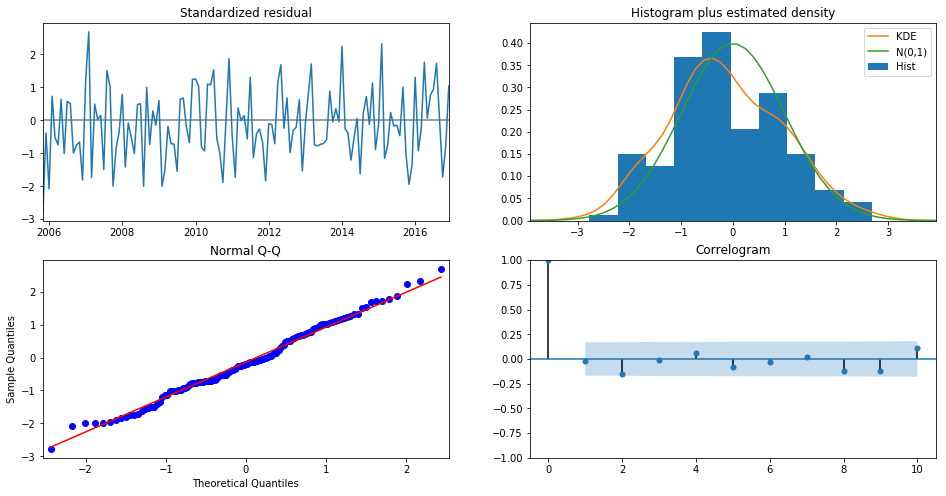

In [31]:
model_SARIMA_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

### Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

### In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

### In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
### The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
### The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
### Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Validating Forecasts
### We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.
### The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

### We can plot the real and forecasted values of the energy consumption time series to assess how well we did. The prediction date is set to start from 2017-01-01, which is the start date in the test set, to the end date of the dateset.

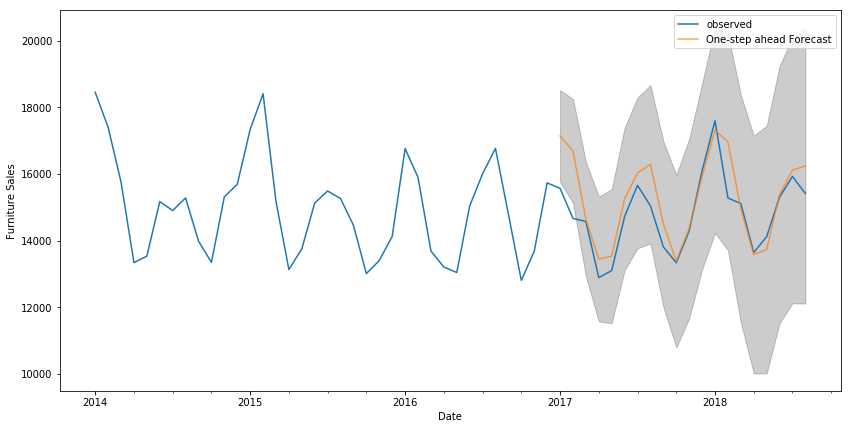

In [32]:
pred_SARIMA = model_SARIMA_fit.get_prediction(start=pd.to_datetime(split_date),
                              end=y.index.max(),
                              dynamic=False)
pred_ci = pred_SARIMA.conf_int()
ax = y['2014':].plot(label='observed')
pred_SARIMA.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Overall, our forecasts align with the true values very well, showing an overall increase trend.

In [33]:
pred_SARIMA = pred_SARIMA.predicted_mean

## MAPE

In [34]:
MAPE(pred_SARIMA,y_test,'SARIMA',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 3.85%


## Producing and Visualizing Forecasts

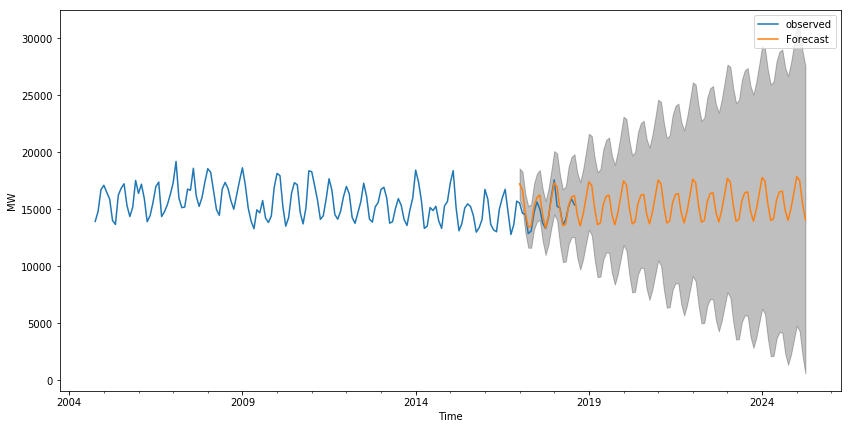

In [35]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

### Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

### As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

# 4. Facebook Prophet
### Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

## 4.1 Fitting the Prophet Model

In [36]:
y_train_fb=y_train.reset_index()

In [37]:
start=timeit.default_timer()
model = Prophet(interval_width=0.95)
model.fit(y_train_fb.rename(columns={'Time':'ds', 'MW':'y'}))
stop=timeit.default_timer()
result_df['Time']['Prophet']=round(stop-start,2)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 4.2 Forecasting with Prophet Model

In [38]:
y_test_fb=y_test.reset_index()

In [39]:
forecast_time=pd.DataFrame(y_test_fb['Time'])
forecast_time.columns=['ds']

In [40]:
y_forecast_fb = model.predict(forecast_time)
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,14642.548009,15279.833051,17642.053655,14642.139957,14643.236795,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,0.0,0.0,0.0,16532.537524


## 4.3 Forecast Evaluation

## MAPE

In [41]:
MAPE(y_forecast_fb['yhat'],y_test_fb['MW'],'Prophet',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 4.0%


In [42]:
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,14642.548009,15279.833051,17642.053655,14642.139957,14643.236795,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,1889.989515,0.0,0.0,0.0,16532.537524


In [43]:
df1=pd.DataFrame(y_forecast_fb['yhat'])
df2=df1.set_index(y_forecast_fb['ds'])

In [44]:
df3=pd.DataFrame(y_forecast_fb[['yhat_lower','yhat_upper']])
df4=df3.set_index(y_forecast_fb['ds'])

## 4.4 Prediction Visualization

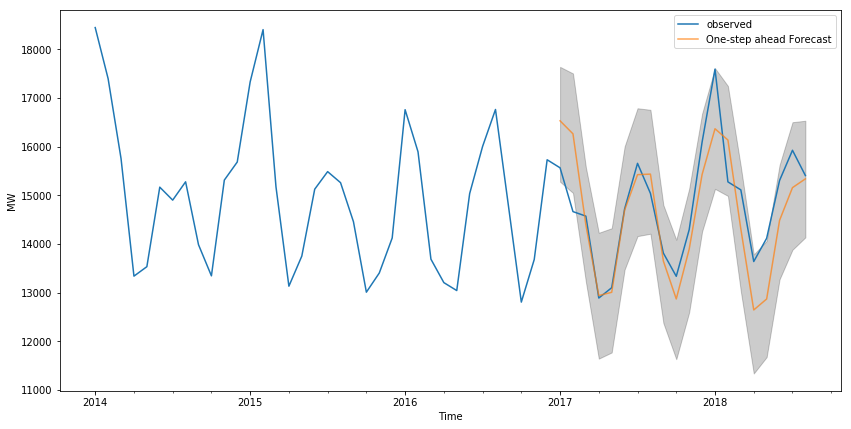

In [45]:
ax = y['2014':].plot(label='observed')
df2.iloc[:,0].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(df4.index,
                df4.iloc[:, 0],
                df4.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

# 5. Recurrent Neural Network - LSTM

In [46]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [47]:
y_train_array=y_train.values

In [48]:
# define training data
y_train_array.shape

(147,)

In [49]:
# reshape training data
n_features = 1
y_train_array = y_train_array.reshape((len(y_train_array), n_features))
y_train_array.shape

(147, 1)

## 5.1 TimeseriesGenerator 

### Keras provides the TimeseriesGenerator that can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.

In [50]:
# define generator
n_input = 6
generator = TimeseriesGenerator(y_train_array, y_train_array, length=n_input, batch_size=len(y_train_array)-n_input)
generator

In [51]:
# define model
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [52]:
len(generator)

1

## 5.2 Fitting LSTM Model

In [53]:
start=timeit.default_timer()
model_lstm.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)
stop=timeit.default_timer()
result_df['Time']['LSTM']=round(stop-start,2)

In [54]:
pred_lstm=[]
# make a one step prediction out of sample
for i in range(0,len(y_test)):
    x_past=y.values[len(y_train)-n_input+i:len(y_train)+i]
    x_input = x_past.reshape((1, n_input, n_features))
    yhat = model_lstm.predict(x_input, verbose=0)
    pred_lstm.append(yhat[0,0])

## 5.3 Prediction Evaluation

In [55]:
MAPE(pred_lstm,y_test.values,'LSTM',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 3.9%


# 6. Supervised Learning - XBoost

## 6.1 Feature Engineering with TSFRESH

### TSFRESH stands for “ Time Series Feature extraction based on scalable hypothesis tests”. tsfresh is a python package. It automatically calculates a large number of time series characteristics, the so called features. Further the package contains methods to evaluate the explaining power and importance of such characteristics for regression or classification tasks.

https://github.com/blue-yonder/tsfresh/tree/master/notebooks

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

In [57]:
%load_ext autoreload
%autoreload 2

In [58]:
from tsfresh.utilities.dataframe_functions import roll_time_series

In [59]:
df_shift, ts_y = make_forecasting_frame(y, kind="price", max_timeshift=10, rolling_direction=1)

In [60]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                     show_warnings=False)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.84it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__

In [61]:
col_drop=[]
for i in range(len(X.columns)):
    if ((X.iloc[:,i]==0).sum())==len(X):
       col_drop.append(X.columns[i])

In [62]:
for i in col_drop:
    X=X.drop(i,axis=1)

In [63]:
len(X.columns)

267

In [64]:
split_date = '2017-01-01'
x_train = X.loc[X.index < split_date].copy()
x_test = X.loc[X.index >= split_date].copy()

y_train = ts_y.loc[X.index < split_date].copy()
y_test = ts_y.loc[X.index >= split_date].copy()

In [65]:
len(y_train)

146

In [66]:
y_train.head(1)

Time
2004-11-01    14830.440278
Freq: MS, Name: value, dtype: float64

In [67]:
X.head(1)

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.75,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2004-11-01,1.945338e+08,0.0,0.0,0.0,0.0,17251.090054,-1.0,-71.563853,15604.024561,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
len(x_train)

146

In [69]:
len(x_test)

20

In [70]:
len(y_test)

20

In [71]:
x_test.head(1)

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.75,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2.112481e+09,11254.617677,-0.130883,-0.280491,0.192735,16004.576613,1.0,760.724462,14195.401403,1.0,...,1.0,1.0,1.0,1.0,1.0,1.249002e+11,1.311884e+11,2.266749e+11,1.728130e+06,1.0


In [72]:
y_test.head(1)

Time
2017-01-01    15566.197581
Freq: MS, Name: value, dtype: float64

## 6.2 XGBoost Modeling

In [73]:
from sklearn import ensemble
from xgboost import XGBRegressor as xgb
start=timeit.default_timer()
model = xgb()
model.fit(x_train,y_train)
stop=timeit.default_timer()
result_df['Time']['XGBoost']=round(stop-start,2)

In [74]:
y_pred = model.predict(data=x_test)
y_pred

array([16690.709, 16472.084, 15299.376, 13203.342, 14252.714, 15625.081,
       17217.84 , 16584.635, 14121.787, 13587.954, 14615.471, 15572.291,
       17206.473, 16937.984, 14753.439, 13501.801, 14632.868, 15981.987,
       16711.908, 16561.357], dtype=float32)

In [75]:
y_test.values

array([15566.19758065, 14665.68452381, 14572.87213997, 12888.32777778,
       13100.91532258, 14722.43055556, 15658.10215054, 15040.50268817,
       13812.88472222, 13335.42204301, 14293.22468793, 16094.72849462,
       17594.875     , 15276.66369048, 15112.57873486, 13639.24444444,
       14117.00537634, 15305.25      , 15926.62231183, 15406.95918367])

In [76]:
len(y_pred)

20

## 6.3 Prediction Evaluation

In [77]:
MAPE(y_pred,y_test.values,'XGBoost',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 5.44%


In [78]:
ts=ts.set_index(pd.to_datetime(df['Time']))
ts.head()

,MW
Time,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [79]:
y_pred=pd.DataFrame(y_pred)

In [80]:
y_pred=y_pred.set_index(y_test.index)

## 6.4 Prediction Visualization

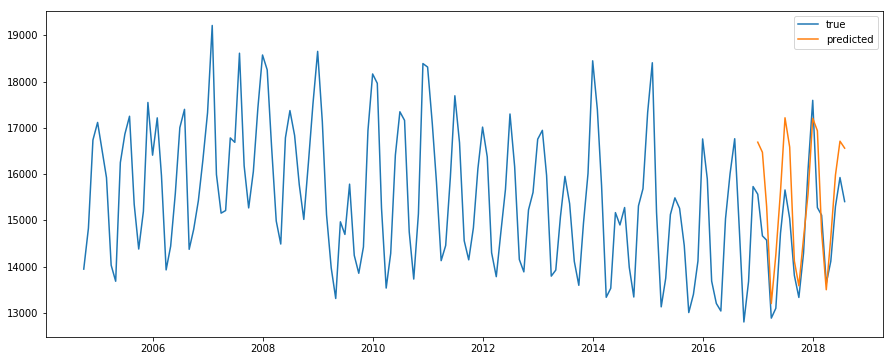

In [81]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

## Result Summary

In [82]:
result_df

,Time,MAPE
MA,1.06,7.74%
SARIMA,0.61,3.85%
HWES,4.11,3.34%
Prophet,0.56,4.0%
LSTM,79.24,3.9%
XGBoost,7.56,5.44%


## Model Accuracy Ranking

In [83]:
result_df.sort_values(by='MAPE', ascending=True)

,Time,MAPE
HWES,4.11,3.34%
SARIMA,0.61,3.85%
LSTM,79.24,3.9%
Prophet,0.56,4.0%
XGBoost,7.56,5.44%
MA,1.06,7.74%


## Modeling Time Ranking

In [84]:
result_df.sort_values(by='Time', ascending=True)

,Time,MAPE
Prophet,0.56,4.0%
SARIMA,0.61,3.85%
MA,1.06,7.74%
HWES,4.11,3.34%
XGBoost,7.56,5.44%
LSTM,79.24,3.9%


## Conclusion

## This project uses different approach to predict the energy consumption. With modeling time and accuracy in consideration, the SARIMA model performs the best overall. Facebook developed library Prophet comes in the second top performance. Several hyperparameters fine tune exploration can be conducted for further study.